In [ ]:
library(parallel)
detectCores()

In [ ]:
library(sparklyr)

In [ ]:
sc <- spark_connect(master = "local")

In [ ]:
sc

In [ ]:
library(dplyr)
iris_tbl <- copy_to(sc, iris)

In [ ]:
iris_tbl
sdf_nrow(iris_tbl)

In [ ]:
cars_tbl <- copy_to(sc, cars, "cars")

In [ ]:
cars_tbl

In [ ]:
sdf_nrow(cars_tbl)

In [ ]:
batting_tbl <- copy_to(sc, Lahman::Batting, "batting")

In [ ]:
sdf_nrow(batting_tbl)

In [ ]:
dplyr::src_tbls(sc)

In [ ]:
flights_tbl <- copy_to(sc, nycflights13::flights, "flights", overwrite=TRUE)

In [ ]:
sdf_nrow(flights_tbl)

In [1]:
# library(rsparkling)
# library(sparklyr)
# library(dplyr)
library(h2o)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




In [2]:
library(parallel)
detectCores()
h2o.init(nthreads= 72, max_mem_size ="4g")

[1] 72

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         4 minutes 5 seconds 
    H2O cluster timezone:       Etc/GMT 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.1.3 
    H2O cluster version age:    1 month and 18 days  
    H2O cluster name:           H2O_started_from_R_jovyan_hbo389 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.55 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  72 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.3 (2020-02-29) 



In [ ]:
# h2o.shutdown()

In [7]:
airlinesURL = "https://s3.amazonaws.com/h2o-airlines-unpacked/allyears2k.csv"

In [8]:
airlines.hex = h2o.importFile(path = airlinesURL, destination_frame = "airlines.hex")

  |======================================================================| 100%


In [10]:
summary(airlines.hex)
nrow(airlines.hex)

Warning message in summary.H2OFrame(airlines.hex):
“Approximated quantiles computed! If you are interested in exact quantiles, please pass the `exact_quantiles=TRUE` parameter.”


 Year           Month            DayofMonth     DayOfWeek      
 Min.   :1987   Min.   : 1.000   Min.   : 1.0   Min.   :1.000  
 1st Qu.:1992   1st Qu.: 1.000   1st Qu.: 6.0   1st Qu.:2.000  
 Median :1998   Median : 1.000   Median :14.0   Median :4.000  
 Mean   :1998   Mean   : 1.409   Mean   :14.6   Mean   :3.821  
 3rd Qu.:2003   3rd Qu.: 1.000   3rd Qu.:23.0   3rd Qu.:5.000  
 Max.   :2008   Max.   :10.000   Max.   :31.0   Max.   :7.000  
                                                               
 DepTime          CRSDepTime       ArrTime        CRSArrTime     UniqueCarrier
 Min.   :   1.0   Min.   :   0.0   Min.   :   1   Min.   :   0   US:18729     
 1st Qu.: 927.4   1st Qu.: 908.6   1st Qu.:1117   1st Qu.:1107   UA: 9434     
 Median :1328.2   Median :1319.2   Median :1525   Median :1515   WN: 6170     
 Mean   :1345.8   Mean   :1313.2   Mean   :1505   Mean   :1485   HP: 3451     
 3rd Qu.:1733.8   3rd Qu.:1718.1   3rd Qu.:1916   3rd Qu.:1902   PS: 3212     
 Max.   :2400.

[1] 43978

0.1%      1%     10%     25%   33.3%     50%   66.7%     75%     90%     99% 
-39.000 -26.000 -13.000  -6.000  -3.000   2.000   9.000  14.000  37.000 132.000 
  99.9% 
277.218

[1] 22

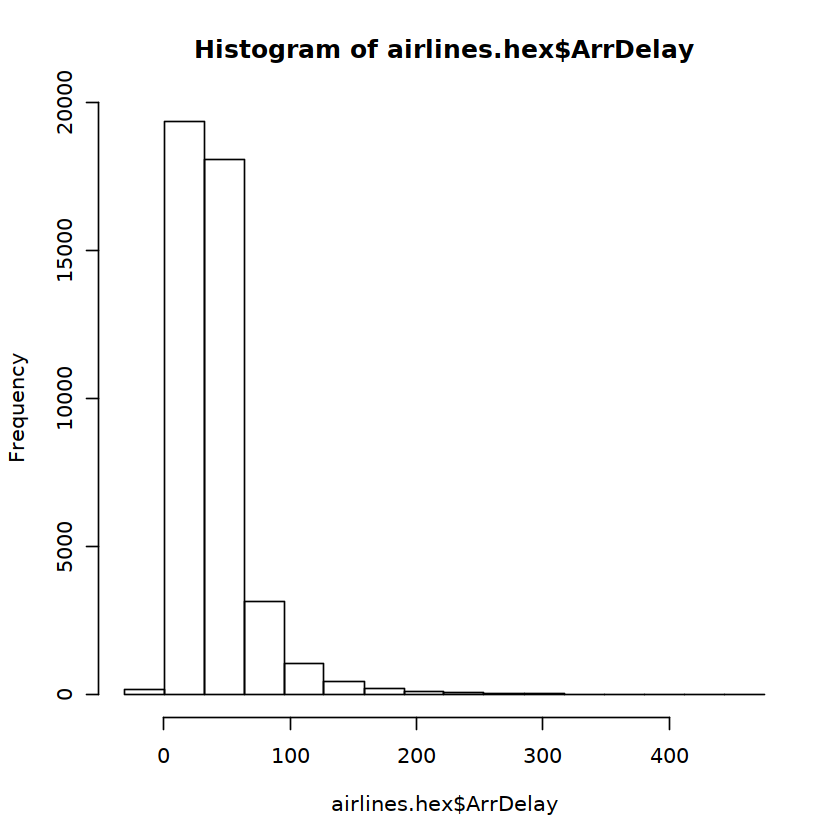

In [11]:
# View quantiles and histograms
# high_na_columns = h2o.ignoreColumns(data = airlines.hex)
quantile(x = airlines.hex$ArrDelay, na.rm = TRUE)
h2o.hist(airlines.hex$ArrDelay)

# Find number of flights by airport
originFlights = h2o.group_by(data = airlines.hex, by ="Origin", nrow("Origin"),gb.control=list(na.methods="rm"))
originFlights.R = as.data.frame(originFlights)

# Find number of flights per month
flightsByMonth = h2o.group_by(data = airlines.hex, by= "Month", nrow("Month"),gb.control=list(na.methods="rm"))
flightsByMonth.R = as.data.frame(flightsByMonth)

# Find months with the highest cancellation ratio
which(colnames(airlines.hex)=="Cancelled")
cancellationsByMonth = h2o.group_by(data = airlines.hex, by = "Month", sum("Cancelled"),gb.control=list(na.methods="rm"))
cancellation_rate = cancellationsByMonth$sum_Cancelled/flightsByMonth$nrow
rates_table = h2o.cbind(flightsByMonth$Month,cancellation_rate)
rates_table.R = as.data.frame(rates_table)

In [16]:
# Construct test and train sets using sampling 
airlines.split = h2o.splitFrame(data = airlines.hex,ratios = 0.85)
airlines.train = airlines.split[[1]]
airlines.test = airlines.split[[2]]

# Display a summary using table-like functions
h2o.table(airlines.train$Cancelled)
h2o.table(airlines.test$Cancelled)

# Set predictor and response variables
Y = "IsDepDelayed"
X = c("Origin", "Dest", "DayofMonth", "Year", "UniqueCarrier", "DayOfWeek", "Month", "DepTime", "ArrTime", "Distance")

# Define the data for the model and display theresults
airlines.glm <- h2o.glm(training_frame=airlines.train, x=X, y=Y, family = "binomial", alpha = 0.5)

# View model information: training statistics,performance, important variables
summary(airlines.glm)

# Predict using GLM model
pred = h2o.predict(object = airlines.glm, newdata = airlines.test)
# Look at summary of predictions: probability of TRUE class (p1)
summary(pred$p1)

  Cancelled Count
1         0 36497
2         1   937

[2 rows x 2 columns] 

  Cancelled Count
1         0  6395
2         1   149

[2 rows x 2 columns] 

  |======================================================================| 100%
Model Details:

H2OBinomialModel: glm
Model Key:  GLM_model_R_1625720099222_11 
GLM Model: summary
    family  link                                regularization
1 binomial logit Elastic Net (alpha = 0.5, lambda = 1.526E-4 )
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                        283                         179                    6
    training_frame
1 RTMP_sid_b6a4_29

H2OBinomialMetrics: glm
** Reported on training data. **

MSE:  0.2137142
RMSE:  0.4622924
LogLoss:  0.6161864
Mean Per-Class Error:  0.3819593
AUC:  0.7191008
AUCPR:  0.7298511
Gini:  0.4382017
R^2:  0.1428976
Residual Deviance:  46132.65
AIC:  46492.65

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
         NO   YES    Error          Rate
NO     6237 11522 0.648798  =11522/17759
YES    2265 17410 0.115121   =2265/19675
Totals 8502 28932 0.368302  =13787/37434

Length  Class   Mode 
     0   NULL   NULL 

In [17]:
# This step takes a few seconds bc we have to download the data from the internet...
train_file <- "https://h2o-public-test-data.s3.amazonaws.com/bigdata/laptop/mnist/train.csv.gz"
test_file <- "https://h2o-public-test-data.s3.amazonaws.com/bigdata/laptop/mnist/test.csv.gz"
train <- h2o.importFile(train_file)
test <- h2o.importFile(test_file)

y <- "C785"  #response column: digits 0-9
x <- setdiff(names(train), y)  #vector of predictor column names

# Since the response is encoded as integers, we need to tell H2O that
# the response is in fact a categorical/factor column.  Otherwise, it 
# will train a regression model instead of multiclass classification.
train[,y] <- as.factor(train[,y])
test[,y] <- as.factor(test[,y])

  |======================================================================| 100%
  |======================================================================| 100%


In [18]:
dl_fit1 <- h2o.deeplearning(x = x,
                            y = y,
                            training_frame = train,
                            model_id = "dl_fit1",
                            hidden = c(20,20),
                            seed = 1)

Warning message in .h2o.processResponseWarnings(res):
“Dropping bad and constant columns: [C86, C85, C729, C728, C646, C645, C169, C760, C561, C53, C11, C55, C10, C54, C57, C12, C56, C58, C17, C19, C18, C731, C730, C20, C22, C21, C24, C23, C26, C25, C28, C27, C702, C701, C29, C700, C1, C2, C784, C3, C783, C4, C782, C5, C781, C6, C142, C7, C141, C8, C9, C31, C30, C32, C759, C758, C757, C756, C755, C477, C113, C674, C112, C673, C672, C84, C83].
”


  |======================================================================| 100%


In [19]:
summary(dl_fit1)

Model Details:

H2OMultinomialModel: deeplearning
Model Key:  dl_fit1 
Status of Neuron Layers: predicting C785, 10-class classification, multinomial distribution, CrossEntropy loss, 14,990 weights/biases, 345.2 KB, 600,000 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1   717     Input  0.00 %       NA       NA        NA       NA       NA
2     2    20 Rectifier  0.00 % 0.000000 0.000000  0.035974 0.080213 0.000000
3     3    20 Rectifier  0.00 % 0.000000 0.000000  0.000164 0.000099 0.000000
4     4    10   Softmax      NA 0.000000 0.000000  0.007348 0.043419 0.000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2    0.021861   0.113446  0.443450 0.102450
3   -0.033933   0.188199  0.980310 0.058007
4   -0.388990   1.135451 -0.246435 0.170216

H2OMultinomialMetrics: deeplearning
** Reported on training data. **
** Metrics reported on temporary training frame with 9959 sa